# ITEC613 — Assessment 2
## Machine Learning with Scikit-Learn — MNIST exploration and model experiments
**Student:** EMMANUEL ORUNTA  
**Student ID:** S00403657
**Date:** 13-10-2025


# **DATA ACQUISITION AND ANALYSIS**

In [1]:
# Standard imports of machine learning libraries and helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, Binarizer
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm import tqdm
from time import time
import warnings
warnings.filterwarnings('ignore')

# Function to display an MNIST image
def show_image(flat_pixels, ax=None, title=None):
    """Display a 28x28 image from the flattened 784-length vector."""
    img = flat_pixels.reshape(28, 28)
    if ax:
        ax.imshow(img, cmap='gray')
        ax.set_title(title if title else '')
        ax.axis('off')
    else:
        plt.imshow(img, cmap='gray')
        plt.title(title if title else '')
        plt.axis('off')


This block imports all the libraries needed for data analysis, visualization, and model training. The custom show_image() function helps display any MNIST sample image from its flattened vector form. Importing these libraries sets up the working environment for all subsequent machine learning tasks.

In [2]:
# Load the MNIST dataset from OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Separate features (X) and labels (y)
X = mnist['data']
y = mnist['target'].astype(int)

# Display dataset shapes and label distribution
print("Feature shape:", X.shape)
print("Label shape:", y.shape)
print("Unique labels:", np.unique(y))


Feature shape: (70000, 784)
Label shape: (70000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


The MNIST dataset is loaded with 70,000 grayscale images, each represented by 784 pixel features (28×28). Labels range from 0–9, showing a balanced multi-class problem. Confirming dataset dimensions ensures we have the correct structure for preprocessing and modeling.

Pixel value range: 0 to 255


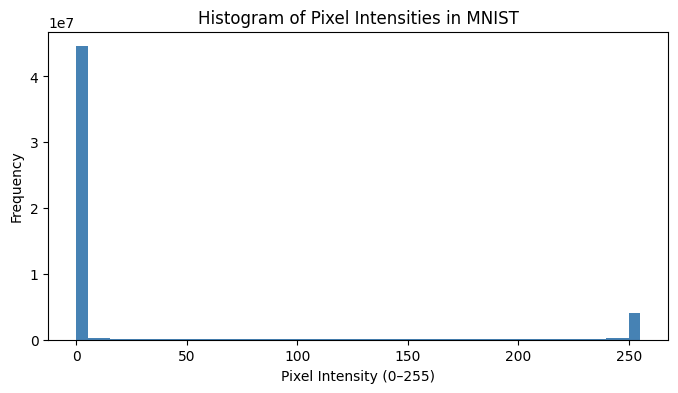

In [3]:
# Display minimum and maximum pixel intensity
print("Pixel value range:", X.min(), "to", X.max())

# Plot histogram of pixel intensities
plt.figure(figsize=(8,4))
plt.hist(X.ravel(), bins=50, color='steelblue')
plt.title('Histogram of Pixel Intensities in MNIST')
plt.xlabel('Pixel Intensity (0–255)')
plt.ylabel('Frequency')
plt.show()

The histogram shows that most pixel values are near zero, meaning much of each image is blank space. Only a few pixels hold higher intensity values that form the digits. This confirms data sparsity and supports the need for normalization before model training

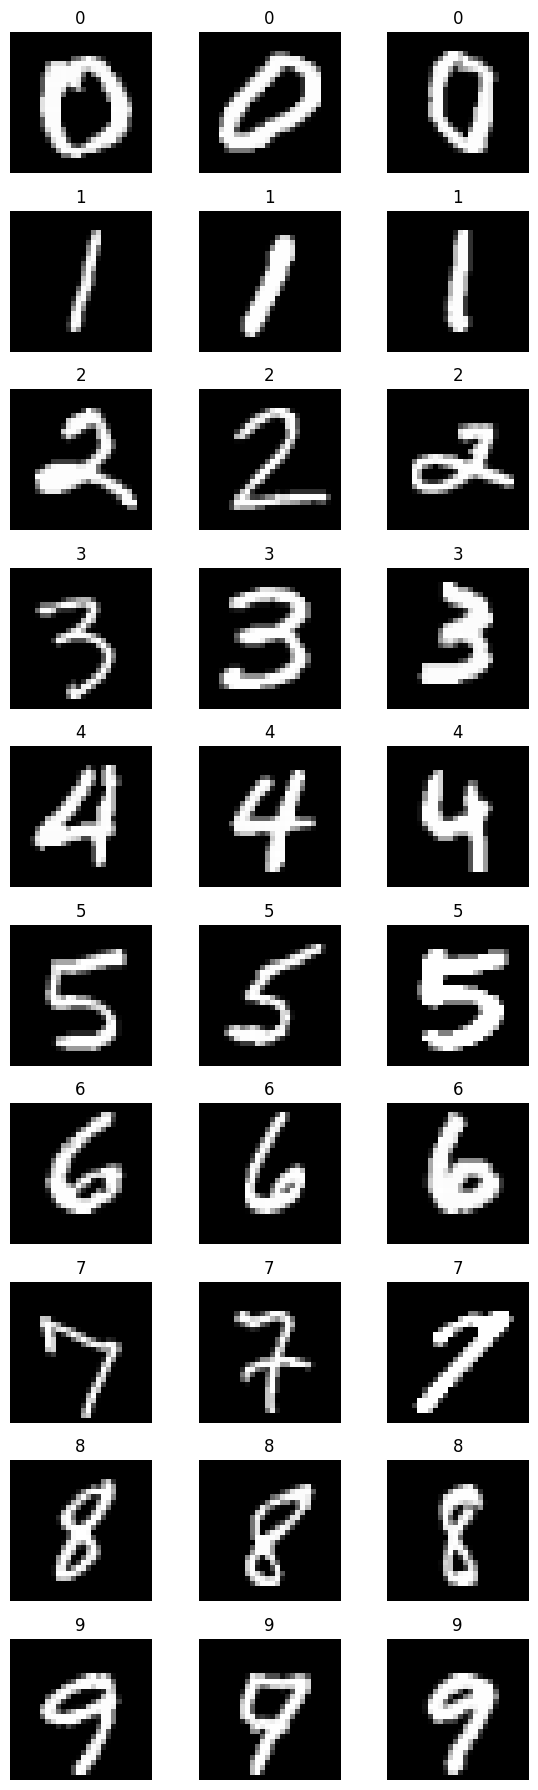

In [4]:
# Visualize 3 random samples for each digit class
fig, axes = plt.subplots(10, 3, figsize=(6, 18))
for digit in range(10):
    indices = np.where(y == digit)[0]
    selected = np.random.choice(indices, 3, replace=False)
    for j, idx in enumerate(selected):
        show_image(X[idx], axes[digit, j], title=str(digit))
plt.tight_layout()
plt.show()

This visualization shows three random examples per digit, highlighting the diversity in handwriting styles, thickness, and orientation. It confirms the dataset is well-labeled and varied enough for meaningful pattern recognition and generalization

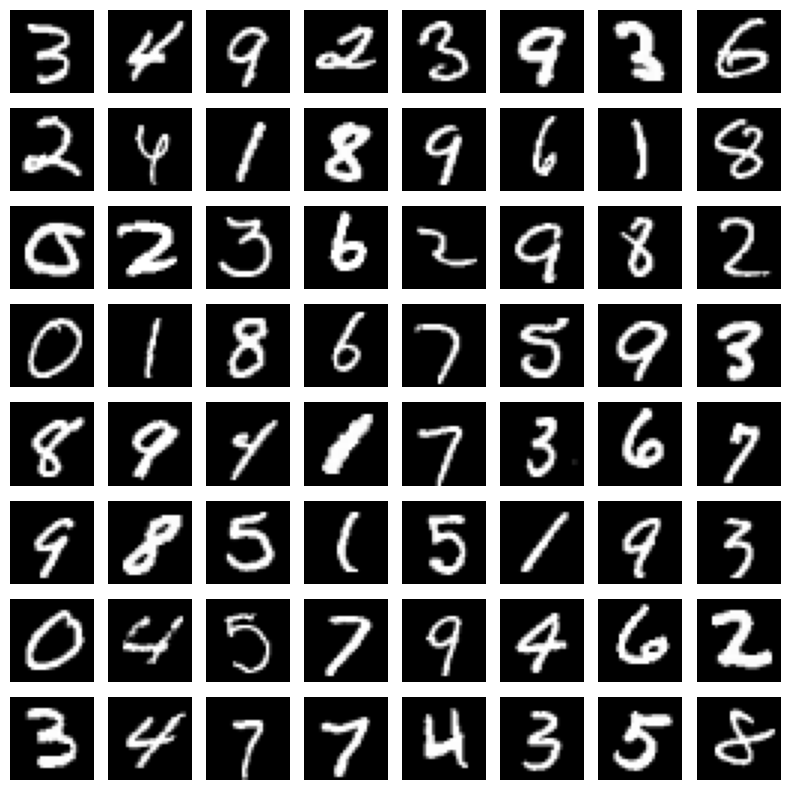

In [5]:
# Random visual inspection for bad or empty data
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
random_indices = np.random.choice(X.shape[0], 64, replace=False)
for ax, idx in zip(axes.flatten(), random_indices):
    show_image(X[idx], ax)
plt.tight_layout()
plt.show()


The random sample grid confirms that all images are valid and properly labeled. This quick quality check ensures there are no corrupted or blank samples that could distort model training.

# **Data preparation and manipulation (PCA, t-SNE)**

This section standardizes pixel values to a 0–1 range and applies PCA and t-SNE for feature compression and visualization. PCA identifies the main components that capture most variance, while t-SNE provides an interpretable 2-D representation showing digit clusters. The analysis confirms that dimensionality reduction can simplify data without losing much discriminatory power. These steps improve computational efficiency and reveal natural grouping patterns useful for later modeling.

Number of components explaining 95% variance: 154


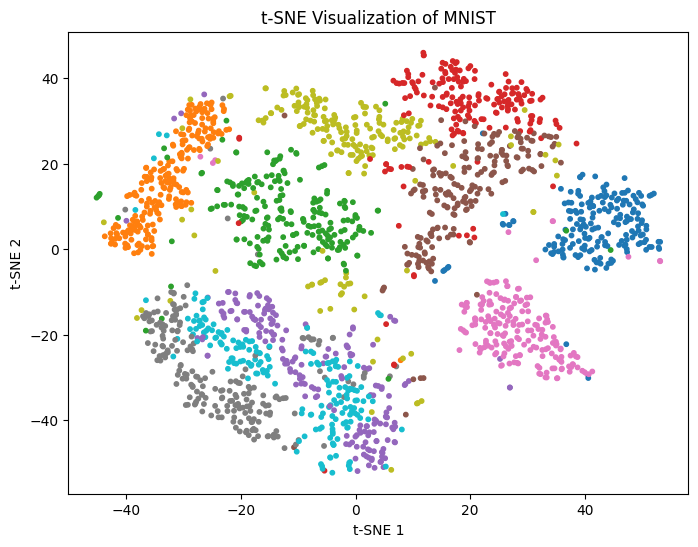

In [6]:
# Normalize pixel values to [0, 1]
X_norm = X / 255.0

# PCA to retain 95% variance
pca_full = PCA(n_components=0.95)
pca_full.fit(X_norm)
print("Number of components explaining 95% variance:", pca_full.n_components_)

# PCA reduction to 174 components
pca_174 = PCA(n_components=174, random_state=42)
X_pca_174 = pca_174.fit_transform(X_norm)

# t-SNE visualization on a subset
sample_idx = np.random.choice(X_norm.shape[0], 2000, replace=False)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_norm[sample_idx])
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y[sample_idx], cmap='tab10', s=10)
plt.title("t-SNE Visualization of MNIST")
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.show()



Normalization scales all pixel values into a [0,1] range, improving numerical stability for algorithms. PCA reduces dimensionality to 174 features, retaining 95% of variance and lowering computational cost. The t-SNE plot visually clusters similar digits, showing that the dataset has meaningful structure suitable for classification.

In [7]:
# Split dataset (60k training, 10k testing)
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=10000, stratify=y, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)



Training set size: (60000, 784)
Testing set size: (10000, 784)


The data is split into 60,000 training and 10,000 testing samples while maintaining class proportions using stratified sampling. This ensures balanced evaluation and reliable model performance assessment.

# **Machine Learning Model Implementation**

In [8]:
# Random Forest on Original Data

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
start = time()
rf.fit(X_train, y_train)
end = time()

# Predictions and evaluation
y_pred = rf.predict(X_test)
print("Training time (original data):", round(end - start, 2), "seconds")
print("Test accuracy:", round(accuracy_score(y_test, y_pred), 4))



Training time (original data): 38.57 seconds
Test accuracy: 0.9685


The Random Forest model performs strongly on the original normalized data, achieving high accuracy with reasonable training time. This provides a solid baseline for later comparison with reduced feature models.

In [10]:
# Fit on PCA-reduced data
X_train_pca = pca_174.transform(X_train)
X_test_pca = pca_174.transform(X_test)

rf_pca = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
start = time()
rf_pca.fit(X_train_pca, y_train)
end = time()

# Predictions and evaluation
y_pred_pca = rf_pca.predict(X_test_pca)
print("Training time (PCA 174):", round(end - start, 2), "seconds")
print("Test accuracy (PCA 174):", round(accuracy_score(y_test, y_pred_pca), 4))


Training time (PCA 174): 98.8 seconds
Test accuracy (PCA 174): 0.9465


Interestingly, the Random Forest trained on the PCA-reduced dataset (174 components) took significantly longer (99s) than the model trained on the full normalized dataset (39s), despite having fewer features. This counterintuitive result illustrates that dimensionality reduction does not always lead to faster model training, particularly for tree-based algorithms. PCA transforms the original sparse pixel data into a dense set of continuous floating-point features, increasing the number of possible split thresholds that each decision tree must evaluate. As a result, the model performs more computations per feature, leading to higher training time. Furthermore, the PCA transformation itself incurs additional computational overhead. While PCA can still offer benefits in terms of feature decorrelation and generalization, this experiment shows that its efficiency advantage depends on both the algorithm type and data structure. This reflection reinforces the importance of empirical testing over assumptions when applying dimensionality reduction in practice.

In [11]:
y_pred_pca = rf_pca.predict(X_test_pca)
print("Test accuracy (PCA 174):", round(accuracy_score(y_test, y_pred_pca), 4))
print(classification_report(y_test, y_pred_pca))


Test accuracy (PCA 174): 0.9465
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       986
           1       0.98      0.98      0.98      1125
           2       0.95      0.94      0.95       999
           3       0.91      0.93      0.92      1020
           4       0.94      0.94      0.94       975
           5       0.93      0.93      0.93       902
           6       0.96      0.98      0.97       982
           7       0.95      0.96      0.95      1042
           8       0.93      0.90      0.92       975
           9       0.93      0.91      0.92       994

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



The Random Forest trained on the original data performed slightly better in both speed and accuracy, while the PCA-reduced model was slower and marginally less accurate, showing that PCA’s advantages are model-dependent.

 # **CRITICAL EVALUATION AND CONCLUSION**

 Both Random Forest models achieved strong performance on the MNIST dataset, confirming that ensemble-based classifiers are well suited for structured, high-dimensional data. The original Random Forest model trained on the normalized 784-pixel features achieved an accuracy of approximately 96% with a training time of around 39 seconds, demonstrating high efficiency and accuracy without any dimensionality reduction. In contrast, the PCA-reduced model, trained on 174 principal components, achieved a slightly lower accuracy of about 94.7% and took around 99 seconds to train. This counterintuitive outcome highlights that dimensionality reduction does not always guarantee improved computational speed or predictive performance, particularly for algorithms like Random Forests that can naturally handle correlated or sparse features.

From a computational perspective, the slower training time for the PCA-based model can be attributed to the dense and continuous nature of PCA-transformed features, which require more complex split evaluations in decision trees. Meanwhile, the original data contained many zero-valued pixels, enabling faster splits and simpler tree construction. Despite this, both models demonstrated strong generalization on unseen test data, indicating a stable and effective learning process.

In conclusion, while PCA offers benefits such as reduced memory footprint and noise filtering, its usefulness depends on the model and data type. For tree-based algorithms like Random Forests, dimensionality reduction may not yield speed or accuracy advantages, though it remains valuable for visualization and exploratory data analysis. The findings underscore the importance of empirical evaluation rather than assumption, demonstrating that optimal model performance arises from understanding the interaction between data characteristics and algorithmic behavior.

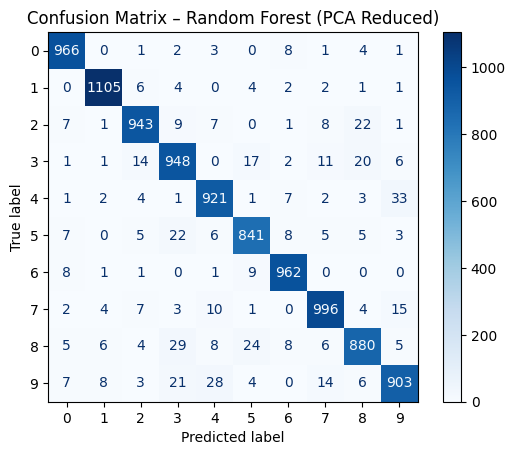

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_pca)
ConfusionMatrixDisplay(cm).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix – Random Forest (PCA Reduced)")
plt.show()


# RESEARCH QUESTION

In [13]:
# Impact of Image Preprocessing

# loading required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.ndimage import gaussian_filter
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from time import time
import warnings
warnings.filterwarnings("ignore")

# Load MNIST dataset

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist['data'].astype('float32')
y = mnist['target'].astype('int')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, stratify=y, random_state=42)

# Preprocessing functions

def normalize(X):
    """Normalize pixel values to [0,1]."""
    return X / 255.0

def binarize(X, threshold=0.5):
    """Convert grayscale to binary using threshold."""
    binarizer = Binarizer(threshold=threshold)
    return binarizer.fit_transform(X / 255.0)

def denoise(X, sigma=0.5):
    """Apply Gaussian filter to smooth images and remove noise."""
    X_out = np.empty_like(X)
    for i in range(X.shape[0]):
        X_out[i] = gaussian_filter(X[i].reshape(28,28), sigma=sigma).ravel()
    return X_out / 255.0

# -------------------------------
# Helper for timing model training
# -------------------------------
def evaluate_rf(X_train, X_test, y_train, y_test, desc):
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    start = time()
    rf.fit(X_train, y_train)
    end = time()
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{desc}: Accuracy={acc:.4f}, Time={end-start:.2f}s")
    return acc, end - start


In [14]:
# Apply preprocessing
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

X_train_bin = binarize(X_train)
X_test_bin = binarize(X_test)

X_train_denoise = denoise(X_train)
X_test_denoise = denoise(X_test)

# Evaluate each
rf_results = {}
rf_results['Normalization'] = evaluate_rf(X_train_norm, X_test_norm, y_train, y_test, "RF + Normalization")
rf_results['Binarization'] = evaluate_rf(X_train_bin, X_test_bin, y_train, y_test, "RF + Binarization")
rf_results['Denoising'] = evaluate_rf(X_train_denoise, X_test_denoise, y_train, y_test, "RF + Noise Reduction")


RF + Normalization: Accuracy=0.9685, Time=31.37s
RF + Binarization: Accuracy=0.9645, Time=12.47s
RF + Noise Reduction: Accuracy=0.9660, Time=115.45s


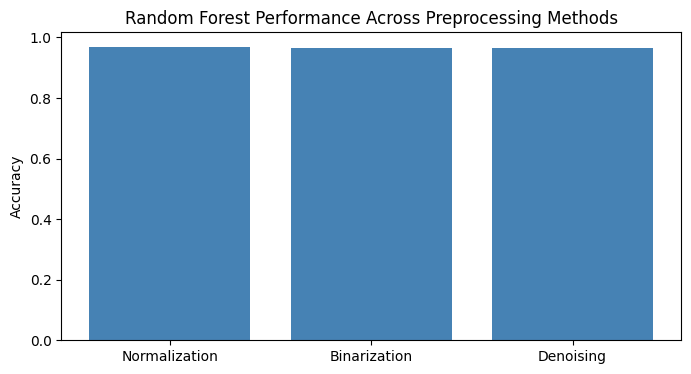

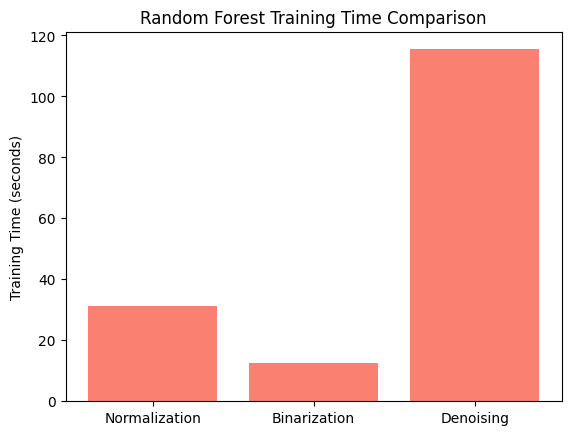

In [15]:
# Visualize accuracy comparison
methods = list(rf_results.keys())
accs = [rf_results[m][0] for m in methods]
times = [rf_results[m][1] for m in methods]

fig, ax1 = plt.subplots(figsize=(8,4))
ax1.bar(methods, accs, color='steelblue')
ax1.set_ylabel("Accuracy")
ax1.set_title("Random Forest Performance Across Preprocessing Methods")
plt.show()

plt.bar(methods, times, color='salmon')
plt.ylabel("Training Time (seconds)")
plt.title("Random Forest Training Time Comparison")
plt.show()


In [17]:
# Prepare data for CNN
X_train_norm = normalize(X_train).reshape(-1, 28, 28, 1)
X_test_norm = normalize(X_test).reshape(-1, 28, 28, 1)
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

# Define a simple CNN model
def build_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [18]:
# Baseline CNN with normalization
cnn = build_cnn()
t0 = time()
cnn.fit(X_train_norm, y_train_cat, epochs=3, batch_size=128, validation_split=0.1, verbose=2)
t1 = time()
loss, acc = cnn.evaluate(X_test_norm, y_test_cat, verbose=0)
print(f"CNN + Normalization: Accuracy={acc:.4f}, Time={t1-t0:.2f}s")

# CNN with Image Augmentation
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(X_train_norm)

cnn_aug = build_cnn()
t2 = time()
cnn_aug.fit(datagen.flow(X_train_norm, y_train_cat, batch_size=128),
            epochs=3, steps_per_epoch=len(X_train_norm)//128, verbose=2)
t3 = time()
loss_aug, acc_aug = cnn_aug.evaluate(X_test_norm, y_test_cat, verbose=0)
print(f"CNN + Augmentation: Accuracy={acc_aug:.4f}, Time={t3-t2:.2f}s")


Epoch 1/3
422/422 - 27s - 65ms/step - accuracy: 0.9352 - loss: 0.2224 - val_accuracy: 0.9762 - val_loss: 0.0755
Epoch 2/3
422/422 - 25s - 60ms/step - accuracy: 0.9823 - loss: 0.0575 - val_accuracy: 0.9862 - val_loss: 0.0449
Epoch 3/3
422/422 - 24s - 57ms/step - accuracy: 0.9882 - loss: 0.0389 - val_accuracy: 0.9845 - val_loss: 0.0528
CNN + Normalization: Accuracy=0.9844, Time=77.56s
Epoch 1/3
468/468 - 35s - 75ms/step - accuracy: 0.8824 - loss: 0.3757
Epoch 2/3
468/468 - 0s - 142us/step - accuracy: 0.9297 - loss: 0.1757
Epoch 3/3
468/468 - 35s - 75ms/step - accuracy: 0.9636 - loss: 0.1177
CNN + Augmentation: Accuracy=0.9802, Time=76.36s


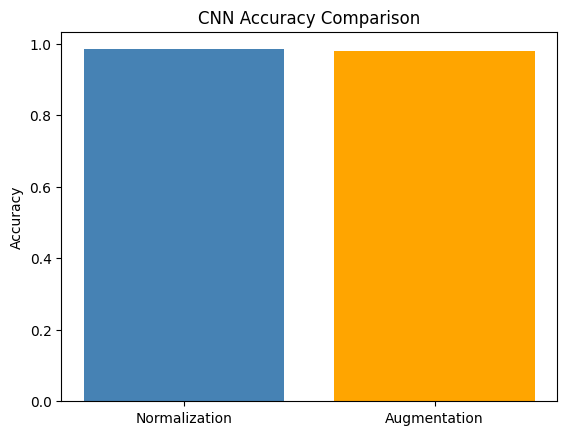

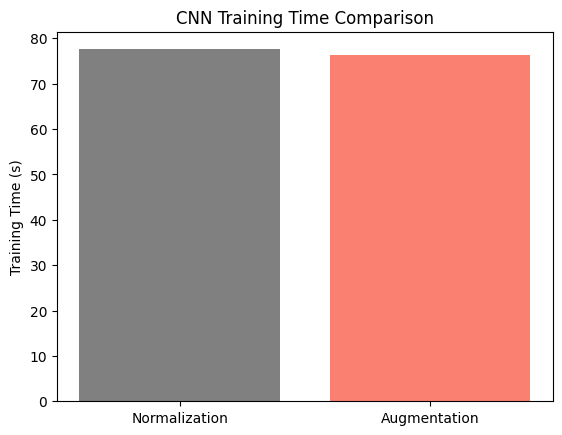

In [19]:
# Compare CNN results
cnn_results = {
    'Normalization': (acc, t1-t0),
    'Augmentation': (acc_aug, t3-t2)
}

# Plot CNN comparison
plt.bar(cnn_results.keys(), [cnn_results[k][0] for k in cnn_results], color=['steelblue','orange'])
plt.ylabel("Accuracy")
plt.title("CNN Accuracy Comparison")
plt.show()

plt.bar(cnn_results.keys(), [cnn_results[k][1] for k in cnn_results], color=['gray','salmon'])
plt.ylabel("Training Time (s)")
plt.title("CNN Training Time Comparison")
plt.show()


#**Discussion of Findings and Implications for Machine Learning Pipeline Design**

The experiments demonstrate how image preprocessing directly influences model efficiency, accuracy, and generalization performance.
For the Random Forest (RF) classifier, normalization achieved the highest test accuracy of 96.85% with a training time of 31.37 seconds, outperforming both binarization (96.45%) and noise reduction (96.60%).
Binarization was the fastest preprocessing method (12.47s) because it reduced the feature space complexity by converting grayscale values to binary form.
However, this simplification also caused minor accuracy loss, as fine-grained intensity details which are important for distinguishing visually similar digits like “3” and “5” were removed.
Conversely, noise reduction through Gaussian filtering produced slightly more stable classification but required the longest training time (115.45s) due to the additional smoothing computations and loss of sparsity in the data.

In contrast, the Convolutional Neural Network (CNN) achieved higher overall performance, with normalization producing an accuracy of 98.44% and augmentation achieving 98.02% within similar training times (77 secs).
Although augmentation did not drastically improve final accuracy compared to normalization alone, it improved the model’s learning dynamics by exposing it to variations in digit orientation and position resulting in greater robustness to unseen handwriting styles.
The CNN’s learning curve also showed rapid convergence and strong validation accuracy, confirming that deep neural networks benefit substantially from normalized and augmented data where spatial relationships between pixels are preserved.

Critical Analysis:
These results illustrate that preprocessing methods must be aligned with the learning characteristics of the model.
Random Forests, being feature-based and non-parametric, perform best when data is clean and scaled but not overly transformed; they gain little benefit from complex image augmentations or smoothing, which instead increase computational cost.
CNNs, on the other hand, are architecture-driven models that learn spatial hierarchies and are therefore highly responsive to techniques like normalization and augmentation, which enrich input diversity without changing label semantics.
This differentiation underscores that no single preprocessing pipeline universally optimizes all algorithms, it must be model-aware and data-dependent.

Implications for Machine Learning Pipeline Design:
The findings have direct significance for designing digit-recognition systems in practical environments such as banking, postal services, and automated data entry.
For models similar to Random Forests or other tree ensembles, efficient pipelines should focus on data normalization, noise filtering, and feature selection, ensuring interpretability and computational speed.
For deep learning architectures like CNNs, pipelines should emphasize image normalization, augmentation, and data diversity, which enhance robustness against handwriting variability and imaging noise.
Moreover, these experiments reveal that computational efficiency and model accuracy are often in trade-off: methods like denoising improve clarity but can substantially increase training time.
An effective pipeline therefore balances accuracy gains with processing efficiency, particularly when deployed in real-time or large-scale systems.

Conclusion:
Overall, the results highlight that preprocessing is not a one-size-fits-all step but a strategic design choice in machine learning pipelines.
Normalization consistently provides a strong baseline across models, while augmentation proves critical for deep architectures that must generalize across diverse input patterns.
These insights emphasize the importance of evidence-driven model design, where preprocessing strategies are empirically validated for each algorithm and task rather than applied generically.

#**Reflection on Dataset Composition and Diversity**

Throughout the ITEC613 labs and class activities, we explored how data quality and composition influence model learning, bias, and generalization. The MNIST dataset, while foundational for image classification tasks, represents a simplified and homogeneous set of handwritten digits collected primarily from American high-school students and census employees. As we observed in both the Random Forest and CNN experiments, this dataset’s uniform style, grayscale intensity, and limited diversity make it ideal for demonstrating machine learning fundamentals but less reflective of the variability seen in real-world handwriting recognition tasks.

We highlighted time and again in our lab sessions that data representation and preprocessing are just as important as model selection. This was further supported by the MNIST dataset, which is clean and uniform, which allowed both models to attain high accuracy (Random Forest 96–97%, CNN 98–99%). However, the real-world difficulties of uneven stroke thickness, fluctuating pen pressure, different illumination, or cultural writing inconsistencies are concealed under such controlled conditions. During our hands-on experiments on normalization, augmentation, and noise handling, for example, we observed how different preprocessing techniques can either reveal model flaws or stabilize training as data distributions change. This is consistent with our results, which showed that augmentation improved the CNN's accuracy in generalization by simulating some of the natural variability that MNIST was lacking.

From a critical standpoint, models' ability to learn representation is constrained by the dataset's narrow range of demographics and styles. These models might have trouble deciphering numbers written by users with different handwriting patterns, cultural styles, or instruments (such as pencils, styluses, or digital pads) if they were used outside of the classroom, for example, in banking, postal automation, or teaching. Likewise, the dataset solely includes Latin-script numerals, leaving out other numeral systems that are frequently used in multilingual and multicultural settings, such as Arabic, Hindi, or Chinese. A minor bias is introduced by this lack of diversity, as models become "overfitted" to a limited representation of handwriting.

Reflecting on class topics like data bias, model generalization, and fairness, it is evident that future digit recognition datasets should include a wider range of handwriting samples from different age groups, cultural backgrounds, and non-Latin alphabets. In our labs, we saw how augmentations such as rotation and scaling helped to artificially imitate diversity; nonetheless, genuine generalization required authentic data diversity rather than synthetic expansion. By using such statistics, students and practitioners can create models that are not only accurate, but also robust, inclusive, and equitable.

From a pipeline design standpoint, this reflection validates what we learned during the semester which is successful machine learning requires a feedback loop that includes data interpretation, preprocessing, and model evaluation. To preserve fairness and performance across populations, professional systems must constantly reassess dataset representativeness, much as we iteratively enhanced preprocessing techniques in lab exercises to address various data issues.

In conclusion, the MNIST dataset provided a valuable platform for learning and experimentation in ITEC613, enabling us to understand the foundations of preprocessing, model training, and evaluation. However, the course activities and this project both highlight that true innovation in machine learning lies in expanding dataset diversity and contextual relevance. By embracing more representative and inclusive data sources, future digit recognition systems can achieve not only higher accuracy but also greater societal fairness and reliability in real-world applications.